<a href="https://colab.research.google.com/github/He-ya/freeCodeCamp/blob/master/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. 建立自動化的PM2.5監視系統
在這一個實驗中，我們要呼叫API，讓程式拿取目前的PM2.5的資料。然後再利用gropandas畫出台灣空汙地圖。

首先，我們先安裝必要的Library
## 安裝必要library
使用pip安裝套件在notebook裡下載必要libraries。這邊最主要的是geopandas，他是一個類似Pandas套件的，但是是專門適合用來處理地理資訊的。

In [0]:
!pip install geopandas
!pip install descartes
!pip install pysal

    100% |████████████████████████████████| 901kB 22.7MB/s 
    100% |████████████████████████████████| 17.9MB 1.9MB/s 
    100% |████████████████████████████████| 1.5MB 10.0MB/s 
    100% |████████████████████████████████| 2.8MB 12.0MB/s 
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built pyproj munch
    1

In [0]:
# OS相關的libraries
import zipfile, io

# 用來處理呼叫API的相關library
import urllib.request, requests
import json

# 科學運算相關的library
import pandas as pd
import numpy as np

# 視覺化套件的設計
import matplotlib.pyplot as plt
import geopandas as gp
from IPython.display import display
from pprint import pprint


## 取得PM2.5資料

透過opendata API下載當下之有檢測PM2.5各鄉鎮之資料。這裡我們使用urllib這個library取得資料並使用pandas製作成Dataframe供後續處理。

透過轉換成Dataframe的table格式，資料顯示搜集站台(Site)與縣市(County)。本lab將會把同縣市的PM2.5值平均後繪製成地圖。

In [0]:
with urllib.request.urlopen("http://opendata.epa.gov.tw/ws/Data/ATM00625/?$format=json") as url:
    #data = json.loads(url.read().decode())
    pm25_df = pd.read_json(url.read())
    display(pm25_df.head())
    


,DataCreationDate,ItemUnit,PM25,Site,county
0,2019-01-12 12:00,μg/m3,45,崙背,雲林縣
1,2019-01-12 12:00,μg/m3,1,富貴角,新北市
2,2019-01-12 12:00,μg/m3,35,麥寮,雲林縣
3,2019-01-12 12:00,μg/m3,7,關山,臺東縣
4,2019-01-12 12:00,μg/m3,13,馬公,澎湖縣


## 使用 Geopandas

下面我們從政府的opendata處下載必要之圖資，此lab我們所使用的是台灣直轄市與縣市地圖。

In [0]:
url = 'http://data.moi.gov.tw/MoiOD/System/DownloadFile.aspx?DATA=72874C55-884D-4CEA-B7D6-F60B0BE85AB0'


r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

我們取出台灣鄉鎮市的shp圖資檔，解開後是一個Dataframe，讓我們看看前五個圖資的資訊。

In [0]:
taiwan_shp = gp.read_file("COUNTY_MOI_1070516.shp", encoding = 'utf-8')

display(taiwan_shp.head())

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,Z,09007,連江縣,Lienchiang County,(POLYGON ((119.9644519140001 25.94552317400007...
1,G,10002,宜蘭縣,Yilan County,(POLYGON ((121.9597084550001 24.84493697000005...
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.4565526600001 24.20718620500008,..."
3,M,10008,南投縣,Nantou County,"POLYGON ((121.2708644380001 24.23660985400005,..."
4,P,10009,雲林縣,Yunlin County,"(POLYGON ((120.081077282 23.52412216400006, 12..."


由於我們的圖資單位是縣市等級，我們把PM2.5全省觀測站的資料，使用groupby把同一個縣市的PM2.5作平均歸入同一縣市。

In [0]:
# 使用groupby 

final_df = pm25_df.groupby(['county'])['PM25'].mean()
taiwan_shp['PM25'] = taiwan_shp['COUNTYNAME'].map(final_df) # Powerful

display(taiwan_shp.head())

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry,PM25
0,Z,09007,連江縣,Lienchiang County,(POLYGON ((119.9644519140001 25.94552317400007...,8.000000
1,G,10002,宜蘭縣,Yilan County,(POLYGON ((121.9597084550001 24.84493697000005...,14.500000
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.4565526600001 24.20718620500008,...",44.000000
3,M,10008,南投縣,Nantou County,"POLYGON ((121.2708644380001 24.23660985400005,...",30.333333
4,P,10009,雲林縣,Yunlin County,"(POLYGON ((120.081077282 23.52412216400006, 12...",34.200000


## 繪圖時間!

接下來我們就開始畫PM2.5的地圖吧。首先我們要設定python的繪圖library - Matplotlib。

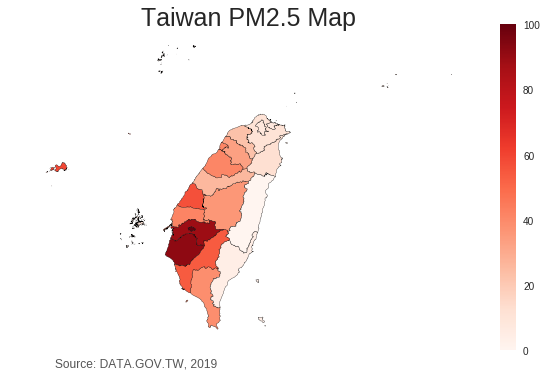

In [0]:
vmin, vmax = 0, 100

# 調整繪圖的參數
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Taiwan PM2.5 Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: DATA.GOV.TW, 2019',xy=(0.1, .08),  xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []

cbar = fig.colorbar(sm)

taiwan_shp.plot(
    edgecolor='black',
    cmap=plt.cm.Reds, #指定顏色
    column='PM25', #指定從自身的這個 column 讀取顏色深度,
    #legend=True,
    ax=ax
)


plt.show()